Vivian Daniela Garavito\
**PRUEBA DATA SCIENTIST R5**

*Importe de librerias*

In [18]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from imblearn.under_sampling import NearMiss
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import OneHotEncoder
import joblib

*Conección con la base de datos*

In [3]:
connection = psycopg2.connect(
    user="postgres",
    password="daniela",
    host="localhost",
    port="5432",
    database="Fraude"
)

In [4]:
# Crear un cursor para ejecutar consultas
cursor = connection.cursor()

Lectura y ejecución Query

In [5]:
# Consulta SQL para seleccionar todos los registros de la tabla
query = "SELECT * FROM fraudes"
cursor.execute(query)

In [6]:
data=cursor.fetchall()
fraude_df=pd.read_sql(query, connection)
fraude_df.head()

,monthh,weekofmonth,dayofweek,make,accidentarea,dayofweekclaimed,monthclaimed,weekofmonthclaimed,sex,maritalstatus,...,ageofpolicyholder,policereportfiled,witnesspresent,agenttype,numberofsuppliments,addresschange_claim,numberofcars,yearr,basepolicy,month_number
0,Dec,2,Friday,Pontiac,Urban,Thursday,Dec,3,Female,Single,...,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision,12
1,May,3,Saturday,Toyota,Urban,Monday,May,5,Male,Married,...,51 to 65,No,No,External,3 to 5,no change,1 vehicle,1994,Liability,5
2,Jul,3,Wednesday,Honda,Urban,Tuesday,Jul,4,Female,Married,...,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision,7
3,Nov,2,Sunday,Honda,Urban,Monday,Nov,2,Female,Single,...,31 to 35,No,No,External,1 to 2,no change,1 vehicle,1994,Liability,11
4,May,1,Sunday,Honda,Urban,Wednesday,May,1,Male,Single,...,16 to 17,No,No,External,none,no change,1 vehicle,1994,Liability,5


**Limpieza y estructuración de datos**

*Revisión e imputación de valores faltantes*

In [8]:
fraude_df.isna().sum(axis=0)[fraude_df.isna().sum(axis=0)!=0]

Series([], dtype: int64)

No se encontraron variables con valores faltantes, por ello no será necesario decidir si realizar imputación por falta de información.

*Revisión de niveles en variables categoricas*

In [121]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['monthh'],normalize='all',dropna=False,margins=True)

monthh,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,All
fraudfound_p,,,,,,,,,,,,,
0,7.782101,6.763943,7.931258,7.678340,8.586252,7.762646,8.047990,8.158236,8.255512,7.490272,8.009079,7.548638,94.014267
1,0.518807,0.544747,0.402075,0.531777,0.564202,0.389105,0.518807,0.661479,0.609598,0.298314,0.453956,0.492866,5.985733
All,8.300908,7.308690,8.333333,8.210117,9.150454,8.151751,8.566796,8.819715,8.865110,7.788586,8.463035,8.041505,100.000000


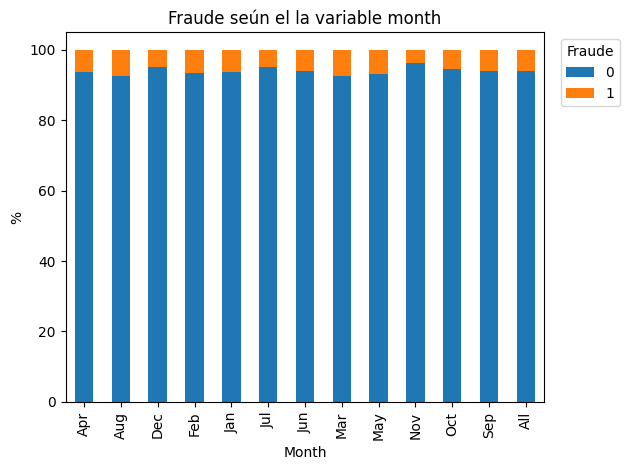

In [170]:
cluster_fraude=100*pd.crosstab(fraude_df['monthh'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
#cluster_ventas=100*pd.crosstab(fraude_df['sex']+1,pd.cut(fraude_df['fraudfound_p'],right=False,bins=6,precision=0),normalize='index',dropna=False).round(3)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Month')
plt.ylabel('%')
plt.title("Fraude seún el la variable month")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


No hay evidencia de que exista alguna relación entre el mes y el fraude.

In [122]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['weekofmonth'],normalize='all',dropna=False,margins=True)

weekofmonth,1,2,3,4,5,All
fraudfound_p,,,,,,
0,19.370947,21.614786,22.211414,20.791180,10.025940,94.014267
1,1.297017,1.459144,1.394293,1.245136,0.590143,5.985733
All,20.667964,23.073930,23.605707,22.036316,10.616083,100.000000


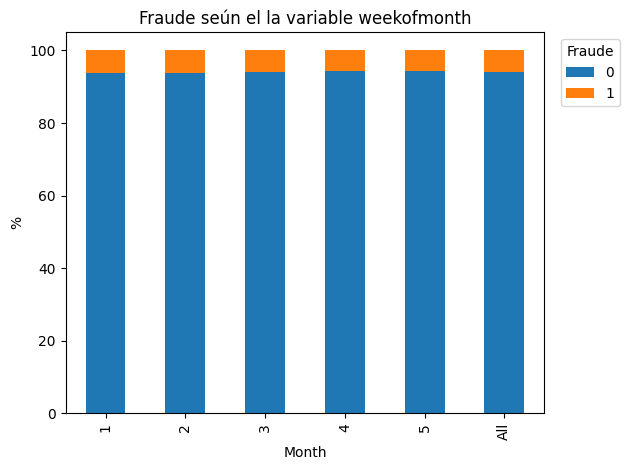

In [171]:
cluster_fraude=100*pd.crosstab(fraude_df['weekofmonth'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
#cluster_ventas=100*pd.crosstab(fraude_df['sex']+1,pd.cut(fraude_df['fraudfound_p'],right=False,bins=6,precision=0),normalize='index',dropna=False).round(3)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Month')
plt.ylabel('%')
plt.title("Fraude seún el la variable weekofmonth")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [123]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['dayofweek'],normalize='all',dropna=False,margins=True)

dayofweek,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,All
fraudfound_p,,,,,,,,
0,14.857328,15.927367,11.997406,10.525292,13.313878,14.137484,13.255512,94.014267
1,0.998703,1.037613,0.856031,0.791180,0.778210,0.778210,0.745785,5.985733
All,15.856031,16.964981,12.853437,11.316472,14.092088,14.915694,14.001297,100.000000


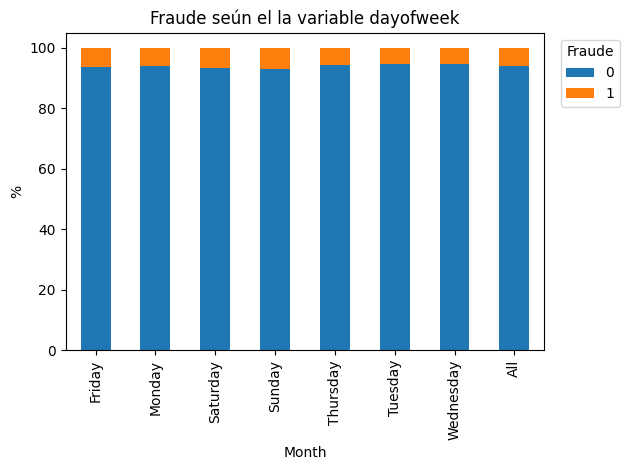

In [172]:
cluster_fraude=100*pd.crosstab(fraude_df['dayofweek'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
#cluster_ventas=100*pd.crosstab(fraude_df['sex']+1,pd.cut(fraude_df['fraudfound_p'],right=False,bins=6,precision=0),normalize='index',dropna=False).round(3)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Month')
plt.ylabel('%')
plt.title("Fraude seún el la variable dayofweek")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [125]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['accidentarea'],normalize='all',dropna=False,margins=True)

accidentarea,Rural,Urban,All
fraudfound_p,,,
0,9.500649,84.513619,94.014267
1,0.862516,5.123217,5.985733
All,10.363165,89.636835,100.000000


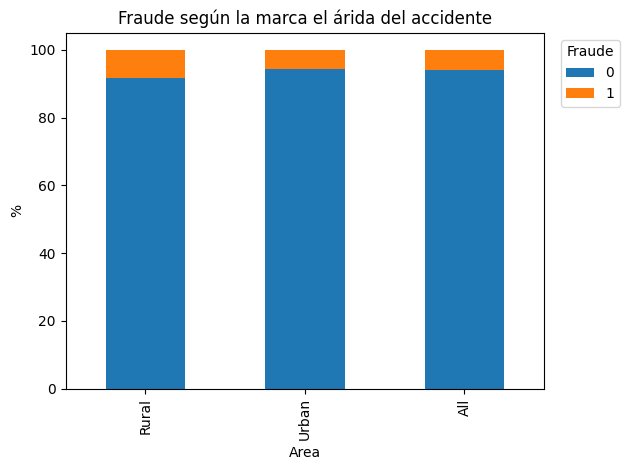

In [175]:
cluster_fraude=100*pd.crosstab(fraude_df['accidentarea'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
#cluster_ventas=100*pd.crosstab(fraude_df['sex']+1,pd.cut(fraude_df['fraudfound_p'],right=False,bins=6,precision=0),normalize='index',dropna=False).round(3)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Area')
plt.ylabel('%')
plt.title("Fraude según la marca el árida del accidente")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [124]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['make'],normalize='all',dropna=False,margins=True)

make,Accura,BMW,Chevrolet,Dodge,Ferrari,Ford,Honda,Jaguar,Lexus,Mazda,Mecedes,Mercury,Nisson,Pontiac,Porche,Saab,Saturn,Toyota,VW,All
fraudfound_p,,,,,,,,,,,,,,,,,,,,
0,2.67834,0.090791,10.291829,0.693904,0.01297,2.704280,17.003891,0.038911,0.006485,14.468223,0.019455,0.499351,0.188067,23.501946,0.032425,0.629053,0.337224,19.033722,1.783398,94.014267
1,0.38262,0.006485,0.609598,0.012970,0.00000,0.214008,1.160830,0.000000,0.000000,0.797665,0.006485,0.038911,0.006485,1.381323,0.000000,0.071336,0.038911,1.206226,0.051881,5.985733
All,3.06096,0.097276,10.901427,0.706874,0.01297,2.918288,18.164721,0.038911,0.006485,15.265888,0.025940,0.538262,0.194553,24.883268,0.032425,0.700389,0.376135,20.239948,1.835279,100.000000


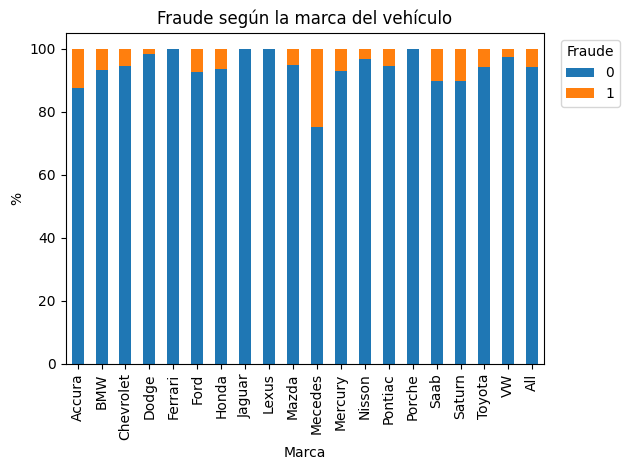

In [174]:
cluster_fraude=100*pd.crosstab(fraude_df['make'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
#cluster_ventas=100*pd.crosstab(fraude_df['sex']+1,pd.cut(fraude_df['fraudfound_p'],right=False,bins=6,precision=0),normalize='index',dropna=False).round(3)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Marca')
plt.ylabel('%')
plt.title("Fraude según la marca del vehículo")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [120]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['sex'],normalize='all',dropna=False,margins=True)


sex,Female,Male,All
fraudfound_p,,,
0,15.012970,79.001297,94.014267
1,0.680934,5.304799,5.985733
All,15.693904,84.306096,100.000000


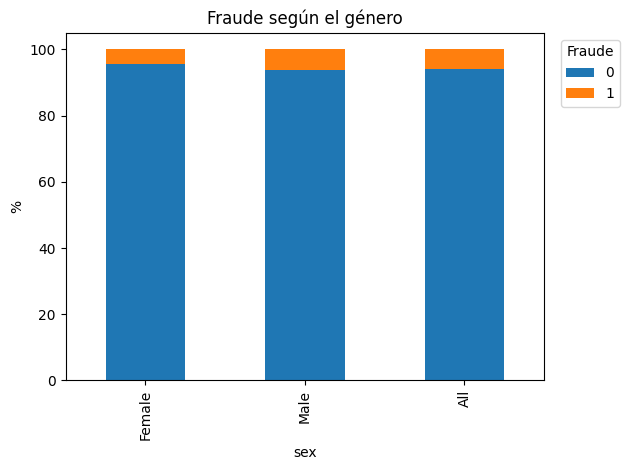

In [182]:
cluster_fraude=100*pd.crosstab(fraude_df['sex'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
#cluster_ventas=100*pd.crosstab(fraude_df['sex']+1,pd.cut(fraude_df['fraudfound_p'],right=False,bins=6,precision=0),normalize='index',dropna=False).round(3)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('sex')
plt.ylabel('%')
plt.title("Fraude según el género")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

Hay gran diferencia entre la cantidad por por marca de los vehículos, se podría considerar crear una nueva vategoría "otros" para aquellas con frecuencia menor a 30

In [126]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['maritalstatus'],normalize='all',dropna=False,margins=True)

maritalstatus,Divorced,Married,Single,Widow,All
fraudfound_p,,,,,
0,0.473411,64.760052,28.573281,0.207523,94.014267
1,0.019455,4.143969,1.802853,0.019455,5.985733
All,0.492866,68.904021,30.376135,0.226978,100.000000


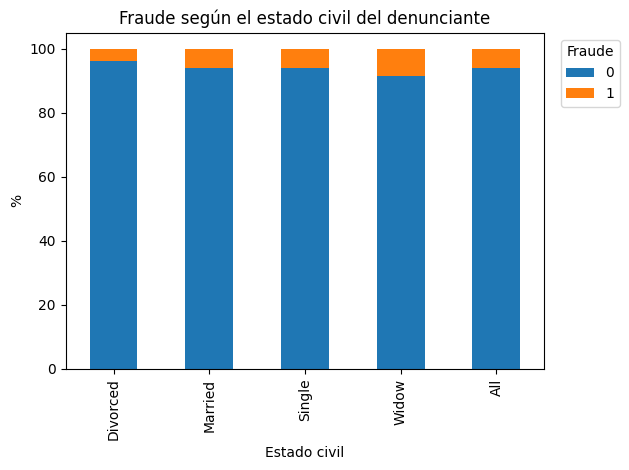

In [183]:
cluster_fraude=100*pd.crosstab(fraude_df['maritalstatus'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
#cluster_ventas=100*pd.crosstab(fraude_df['sex']+1,pd.cut(fraude_df['fraudfound_p'],right=False,bins=6,precision=0),normalize='index',dropna=False).round(3)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Estado civil')
plt.ylabel('%')
plt.title("Fraude según el estado civil del denunciante")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [15]:
# Definir los límites de los intervalos de edad
bins = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 80]

# Definir las etiquetas para los intervalos
labels = ['<20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '>60']

# Aplicar la división en intervalos de edad
fraude_df['ageint'] = pd.cut(fraude_df['age'], bins=bins, labels=labels)


In [135]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['ageint'],normalize='all',dropna=False,margins=True)

ageint,<20,21-25,26-30,31-35,36-40,41-45,46-50,51-55,56-60,>60,All
fraudfound_p,,,,,,,,,,,
0,0.695364,3.841060,17.304636,17.350993,12.523179,12.682119,9.099338,8.675497,4.529801,7.390728,94.014267
1,0.119205,0.218543,1.125828,1.258278,0.841060,0.728477,0.503311,0.450331,0.225166,0.437086,5.985733
All,0.814570,4.059603,18.430464,18.609272,13.364238,13.410596,9.602649,9.125828,4.754967,7.827815,100.000000


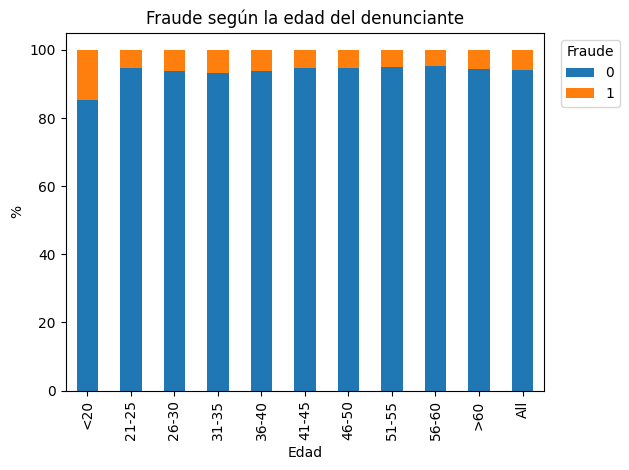

In [184]:
cluster_fraude=100*pd.crosstab(fraude_df['ageint'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Edad')
plt.ylabel('%')
plt.title("Fraude según la edad del denunciante")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [136]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['fault'],normalize='all',dropna=False,margins=True)

fault,Policy Holder,Third Party,All
fraudfound_p,,,
0,67.081712,26.932555,94.014267
1,5.745785,0.239948,5.985733
All,72.827497,27.172503,100.000000


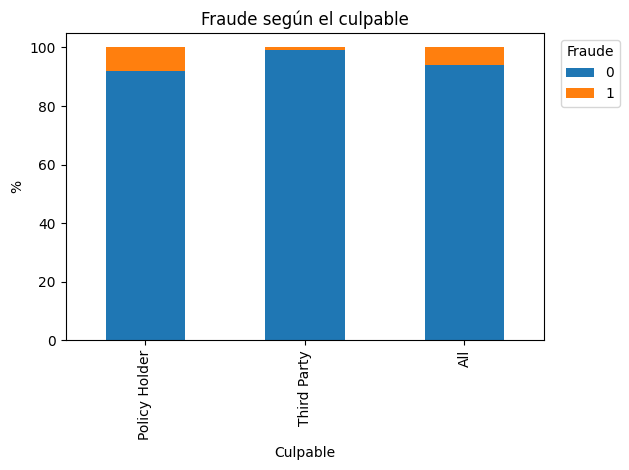

In [185]:
cluster_fraude=100*pd.crosstab(fraude_df['fault'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Culpable')
plt.ylabel('%')
plt.title("Fraude según el culpable")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

Un factor clave en el fraude es si el culpable fue el dueño del seguro u otro involucrado. Esto implica que las reclamaciones en las que el culpable es el dueño de la póliza podrían tener un mayor riesgo de fraude. Recomendación: Establecer procedimientos de verificación y validación más rigurosos para las reclamaciones en las que el culpable es el dueño de la póliza. Esto puede incluir la verificación de documentos y pruebas adicionales, así como la colaboración con las autoridades competentes en caso de sospecha de fraude.


In [137]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['policytype'],normalize='all',dropna=False,margins=True)

policytype,Sedan - All Perils,Sedan - Collision,Sedan - Liability,Sport - All Perils,Sport - Collision,Sport - Liability,Utility - All Perils,Utility - Collision,Utility - Liability,All
fraudfound_p,,,,,,,,,,
0,23.83917,33.722438,32.107652,0.142672,1.945525,0.006485,1.939040,0.175097,0.136187,94.014267
1,2.66537,2.490272,0.233463,0.000000,0.311284,0.000000,0.265888,0.019455,0.000000,5.985733
All,26.50454,36.212711,32.341115,0.142672,2.256809,0.006485,2.204929,0.194553,0.136187,100.000000


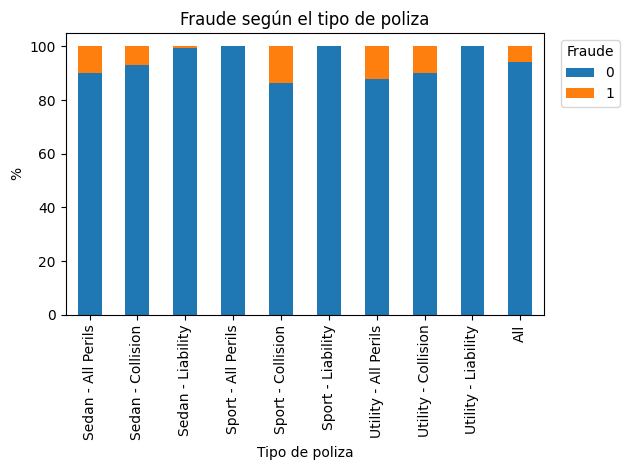

In [186]:
cluster_fraude=100*pd.crosstab(fraude_df['policytype'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Tipo de poliza')
plt.ylabel('%')
plt.title("Fraude según el tipo de poliza")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

La combinación del tipo de auto y el tipo de póliza, muestra una fuerte asociación con el fraude, especialmente en los casos de Sedan - All Perils, Sedan - Collision, Sport - Collision, Utility - All Perils, Utility – Collision. Esto indica que los sedanes con pólizas de colisión y todo riesgo podrían ser más propensos al fraude, en general estos dos tipos de pólizas son más propensas al fruade. Recomendación: Realizar análisis más detallados de los casos de fraude relacionados con pólizas de colisión y todo riesgo. Además, se podría considerar la revisión de las políticas de precios y cobertura para los sedanes y carros de utilidad con el fin de mitigar el riesgo de fraude. Un caso también de particular interés es la combinación de una póliza de colisión para un carro tipo deportivo.

In [139]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['vehiclecategory'],normalize='all',dropna=False,margins=True)

vehiclecategory,Sedan,Sport,Utility,All
fraudfound_p,,,,
0,57.561608,34.202335,2.250324,94.014267
1,5.155642,0.544747,0.285344,5.985733
All,62.717250,34.747082,2.535668,100.000000


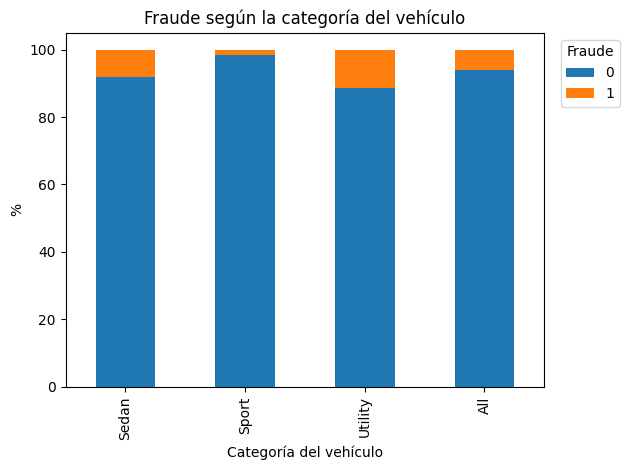

In [188]:
cluster_fraude=100*pd.crosstab(fraude_df['vehiclecategory'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Categoría del vehículo')
plt.ylabel('%')
plt.title("Fraude según la categoría del vehículo")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

Se evidencia que la categoría del vehículo es importante, por ejemplo se puede asumir que no hay gran probabilidad de fraude.

In [190]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['vehicleprice'],normalize='all',dropna=False,margins=True)

vehicleprice,20000 to 29000,30000 to 39000,40000 to 59000,60000 to 69000,less than 20000,more than 69000,All
fraudfound_p,,,,,,,
0,49.662776,21.776913,2.788586,0.538262,6.439689,12.808042,94.014267
1,2.730220,1.134890,0.201038,0.025940,0.667964,1.225681,5.985733
All,52.392996,22.911803,2.989624,0.564202,7.107652,14.033722,100.000000


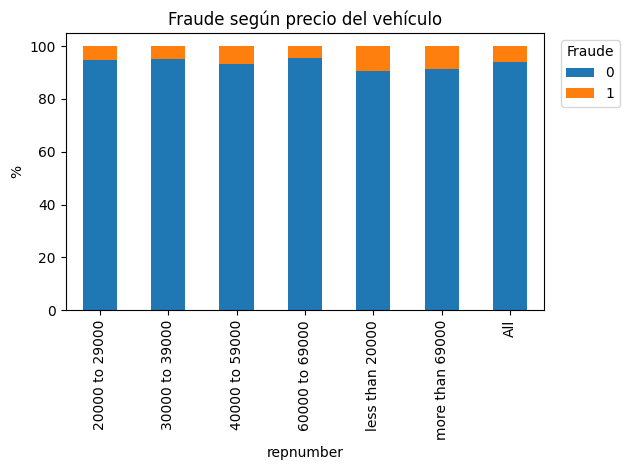

In [191]:
cluster_fraude=100*pd.crosstab(fraude_df['vehicleprice'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('repnumber')
plt.ylabel('%')
plt.title("Fraude según precio del vehículo")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [141]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['deductible'],normalize='all',dropna=False,margins=True)

deductible,300,400,500,700,All
fraudfound_p,,,,,
0,0.038911,90.674449,1.400778,1.900130,94.014267
1,0.012970,5.551232,0.304799,0.116732,5.985733
All,0.051881,96.225681,1.705577,2.016861,100.000000


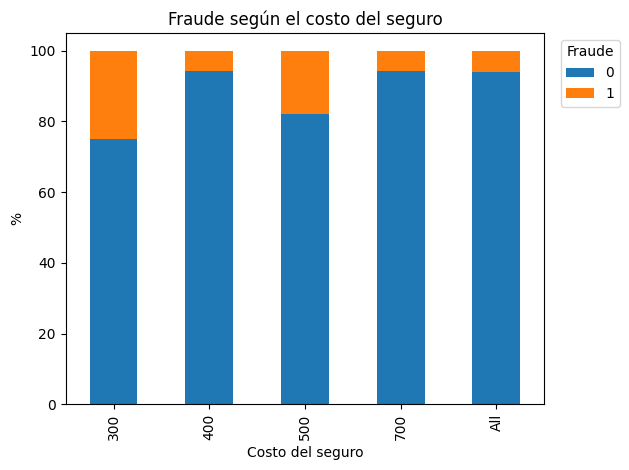

In [194]:
cluster_fraude=100*pd.crosstab(fraude_df['deductible'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Costo del seguro')
plt.ylabel('%')
plt.title("Fraude según el costo del seguro")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

El costo del seguro muestra que los valores de 500 y 300 son más relevantes para la detección de fraudes, a pesar de no ser los más altos en la escala de deducibles. Recomendación: Aunque los valores de deducible de 500 y 300 no son los más altos, resulta evidente que están relacionados con un mayor riesgo de fraude. Por lo tanto, se sugiere implementar medidas adicionales de control y validación en los casos en los que se encuentren estos valores de deducible. Además, es recomendable realizar un monitoreo constante de los casos con deducibles más bajos para identificar cualquier patrón o tendencia que pueda indicar actividad fraudulenta.


In [142]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['driverrating'],normalize='all',dropna=False,margins=True)

driverrating,1,2,3,4,All
fraudfound_p,,,,,
0,24.072633,23.261997,23.618677,23.060960,94.014267
1,1.504540,1.387808,1.569390,1.523995,5.985733
All,25.577173,24.649805,25.188067,24.584955,100.000000


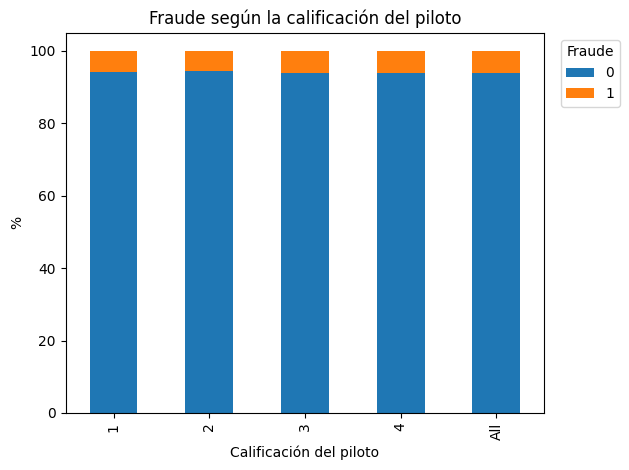

In [195]:
cluster_fraude=100*pd.crosstab(fraude_df['driverrating'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Calificación del piloto')
plt.ylabel('%')
plt.title("Fraude según la calificación del piloto")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [143]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['days_policy_accident'],normalize='all',dropna=False,margins=True)

days_policy_accident,1 to 7,15 to 30,8 to 15,more than 30,none,All
fraudfound_p,,,,,,
0,0.084306,0.298314,0.324254,93.009079,0.298314,94.014267
1,0.006485,0.019455,0.032425,5.869001,0.058366,5.985733
All,0.090791,0.317769,0.356680,98.878080,0.356680,100.000000


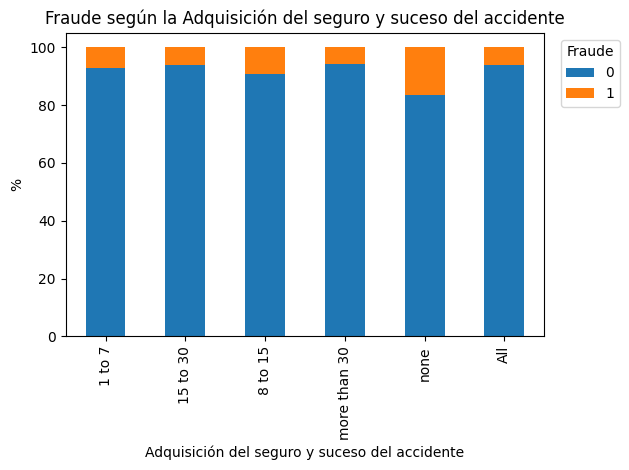

In [196]:
cluster_fraude=100*pd.crosstab(fraude_df['days_policy_accident'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Adquisición del seguro y suceso del accidente')
plt.ylabel('%')
plt.title("Fraude según la Adquisición del seguro y suceso del accidente")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

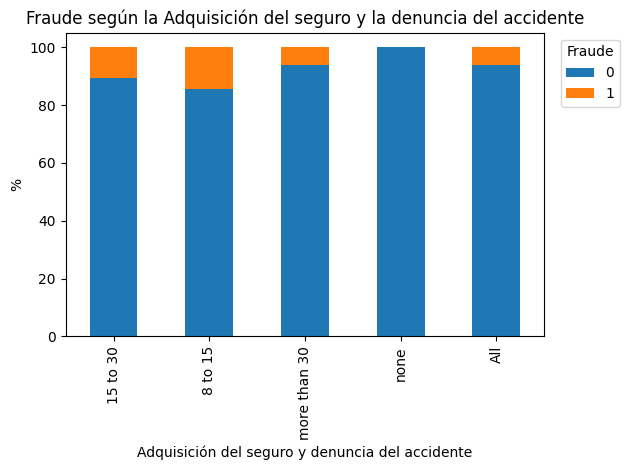

In [197]:
cluster_fraude=100*pd.crosstab(fraude_df['days_policy_claim'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Adquisición del seguro y denuncia del accidente')
plt.ylabel('%')
plt.title("Fraude según la Adquisición del seguro y la denuncia del accidente")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [144]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['pastnumberofclaims'],normalize='all',dropna=False,margins=True)

pastnumberofclaims,1,2 to 4,more than 4,none,All
fraudfound_p,,,,,
0,21.731518,33.664073,12.594034,26.024643,94.014267
1,1.439689,1.906615,0.440986,2.198444,5.985733
All,23.171206,35.570687,13.035019,28.223087,100.000000


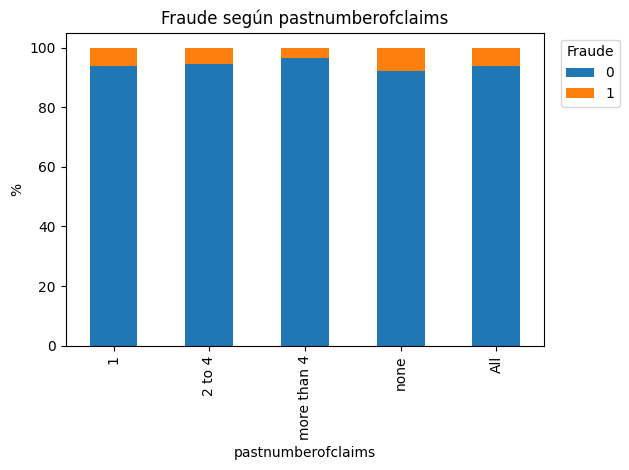

In [199]:
cluster_fraude=100*pd.crosstab(fraude_df['pastnumberofclaims'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('pastnumberofclaims')
plt.ylabel('%')
plt.title("Fraude según pastnumberofclaims")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [145]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['ageofvehicle'],normalize='all',dropna=False,margins=True)

ageofvehicle,2 years,3 years,4 years,5 years,6 years,7 years,more than 7,new,All
fraudfound_p,,,,,,,,,
0,0.453956,0.901427,1.348898,8.184176,20.881971,35.551232,24.481193,2.211414,94.014267
1,0.019455,0.084306,0.136187,0.616083,1.478599,2.107652,1.335927,0.207523,5.985733
All,0.473411,0.985733,1.485084,8.800259,22.360571,37.658885,25.817121,2.418936,100.000000


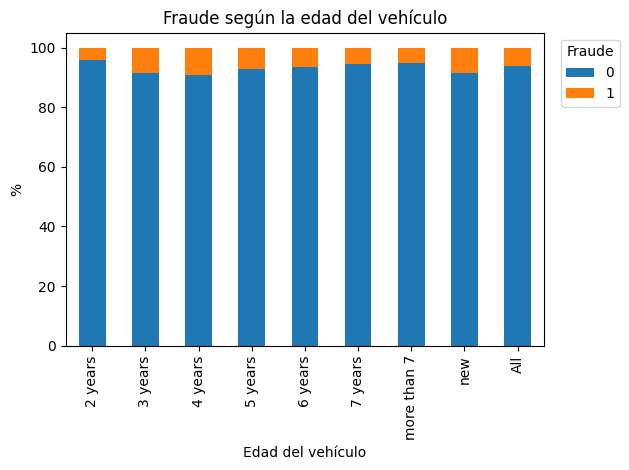

In [201]:
cluster_fraude=100*pd.crosstab(fraude_df['ageofvehicle'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Edad del vehículo')
plt.ylabel('%')
plt.title("Fraude según la edad del vehículo")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [146]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['ageofpolicyholder'],normalize='all',dropna=False,margins=True)

ageofpolicyholder,16 to 17,18 to 20,21 to 25,26 to 30,31 to 35,36 to 40,41 to 50,51 to 65,over 65,All
fraudfound_p,,,,,,,,,,
0,1.874189,0.084306,0.596628,3.761349,33.936446,24.682231,17.405966,8.573281,3.099870,94.014267
1,0.201038,0.012970,0.103761,0.214008,2.334630,1.536965,0.933852,0.453956,0.194553,5.985733
All,2.075227,0.097276,0.700389,3.975357,36.271077,26.219196,18.339818,9.027237,3.294423,100.000000


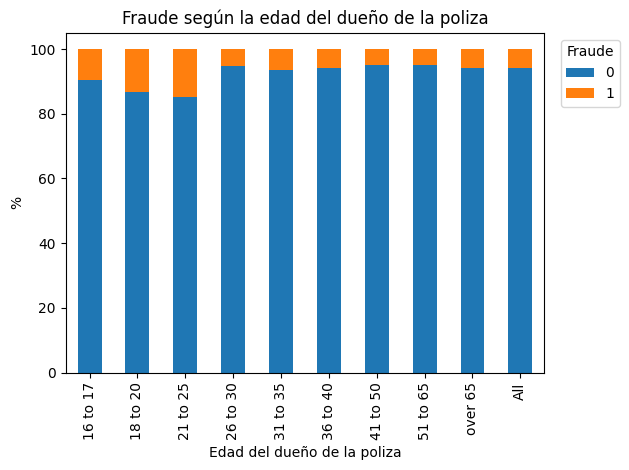

In [203]:
cluster_fraude=100*pd.crosstab(fraude_df['ageofpolicyholder'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Edad del dueño de la poliza')
plt.ylabel('%')
plt.title("Fraude según la edad del dueño de la poliza")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [148]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['policereportfiled'],normalize='all',dropna=False,margins=True)

policereportfiled,No,Yes,All
fraudfound_p,,,
0,91.342412,2.671855,94.014267
1,5.881971,0.103761,5.985733
All,97.224384,2.775616,100.000000


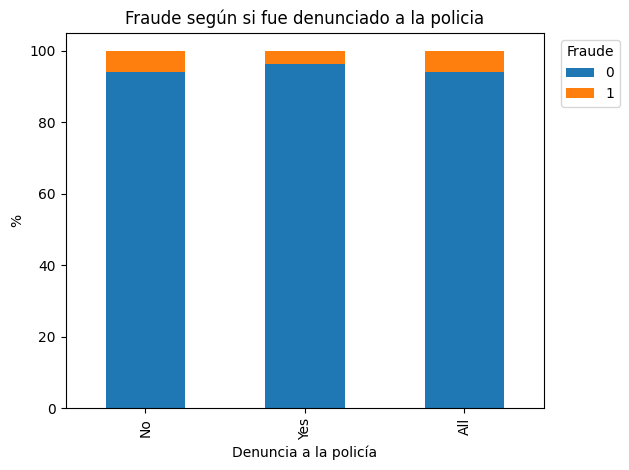

In [204]:
cluster_fraude=100*pd.crosstab(fraude_df['policereportfiled'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Denuncia a la policía')
plt.ylabel('%')
plt.title("Fraude según si fue denunciado a la policia")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [149]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['witnesspresent'],normalize='all',dropna=False,margins=True)

witnesspresent,No,Yes,All
fraudfound_p,,,
0,93.469520,0.544747,94.014267
1,5.966278,0.019455,5.985733
All,99.435798,0.564202,100.000000


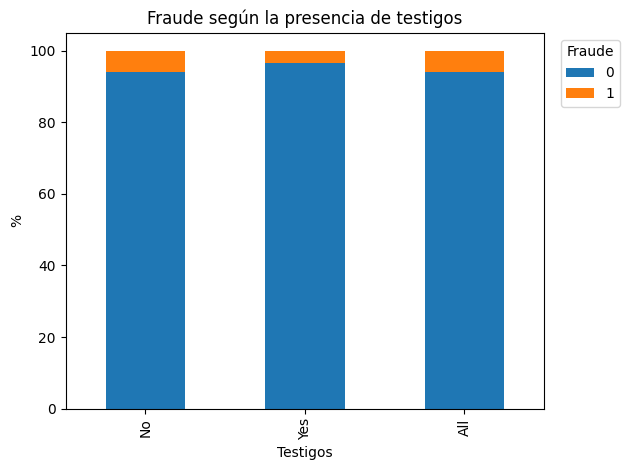

In [205]:
cluster_fraude=100*pd.crosstab(fraude_df['witnesspresent'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Testigos')
plt.ylabel('%')
plt.title("Fraude según la presencia de testigos")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [150]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['agenttype'],normalize='all',dropna=False,margins=True)

agenttype,External,Internal,All
fraudfound_p,,,
0,92.477302,1.536965,94.014267
1,5.959792,0.025940,5.985733
All,98.437095,1.562905,100.000000


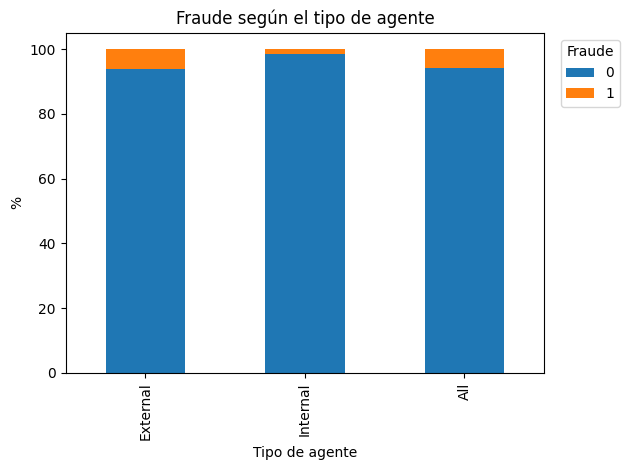

In [206]:
cluster_fraude=100*pd.crosstab(fraude_df['agenttype'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Tipo de agente')
plt.ylabel('%')
plt.title("Fraude según el tipo de agente")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [151]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['numberofsuppliments'],normalize='all',dropna=False,margins=True)

numberofsuppliments,1 to 2,3 to 5,more than 5,none,All
fraudfound_p,,,,,
0,15.110246,12.451362,23.813230,42.639429,94.014267
1,1.031128,0.629053,1.264591,3.060960,5.985733
All,16.141375,13.080415,25.077821,45.700389,100.000000


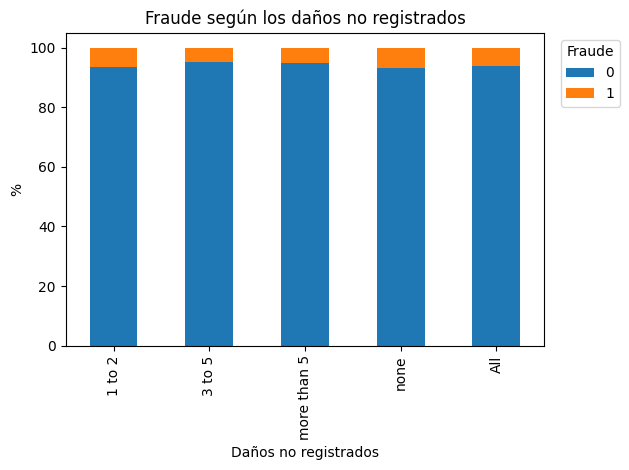

In [207]:
cluster_fraude=100*pd.crosstab(fraude_df['numberofsuppliments'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Daños no registrados')
plt.ylabel('%')
plt.title("Fraude según los daños no registrados")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [152]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['numberofcars'],normalize='all',dropna=False,margins=True)

numberofcars,1 vehicle,2 vehicles,3 to 4,5 to 8,more than 8,All
fraudfound_p,,,,,,
0,87.328145,4.319066,2.224384,0.129702,0.01297,94.014267
1,5.512322,0.278859,0.188067,0.006485,0.00000,5.985733
All,92.840467,4.597925,2.412451,0.136187,0.01297,100.000000


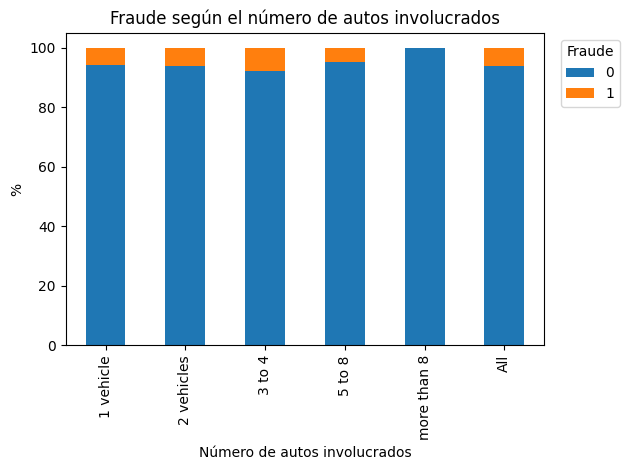

In [209]:
cluster_fraude=100*pd.crosstab(fraude_df['numberofcars'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Número de autos involucrados')
plt.ylabel('%')
plt.title("Fraude según el número de autos involucrados")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [154]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['yearr'],normalize='all',dropna=False,margins=True)

yearr,1994,1995,1996,All
fraudfound_p,,,,
0,37.178988,31.738003,25.097276,94.014267
1,2.652399,1.952010,1.381323,5.985733
All,39.831388,33.690013,26.478599,100.000000


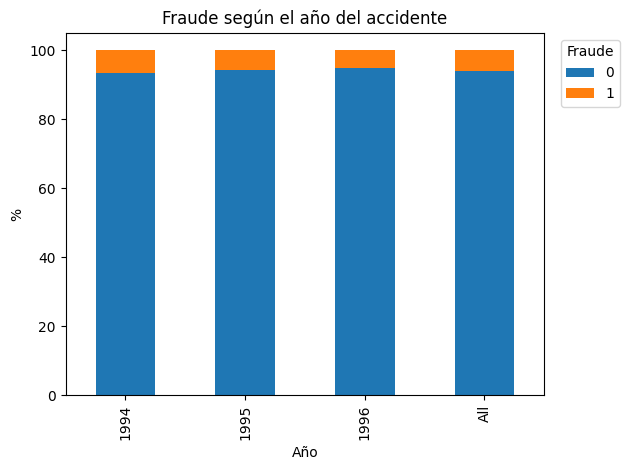

In [211]:
cluster_fraude=100*pd.crosstab(fraude_df['yearr'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('Año')
plt.ylabel('%')
plt.title("Fraude según el año del accidente")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [155]:
100*pd.crosstab(fraude_df['fraudfound_p'],fraude_df['basepolicy'],normalize='all',dropna=False,margins=True)

basepolicy,All Perils,Collision,Liability,All
fraudfound_p,,,,
0,25.920882,35.843061,32.250324,94.014267
1,2.931258,2.821012,0.233463,5.985733
All,28.852140,38.664073,32.483787,100.000000


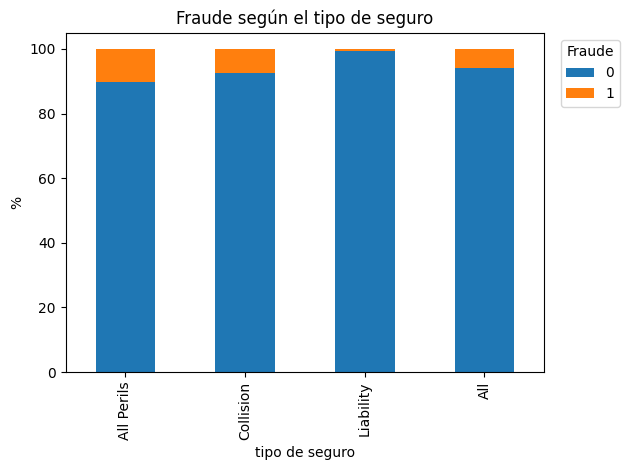

In [213]:
cluster_fraude=100*pd.crosstab(fraude_df['basepolicy'],fraude_df['fraudfound_p'],normalize='index',dropna=False,margins=True)
ax=cluster_fraude.plot.bar(stacked=True)
plt.xlabel('tipo de seguro')
plt.ylabel('%')
plt.title("Fraude según el tipo de seguro")
ax.legend(title='Fraude', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

Aunque bien, es un complemento del insights#2, el tipo de seguro es especialmente importante para descartar fraudes cuando el tipo de seguro es Liability (responsabilidad civil). Esto sugiere que los casos de fraude están más relacionados con los tipos de seguro Collision y All Perils, (Colisión y Todo riesgo). Recomendación: Realizar un análisis más detallado de los casos de fraude asociados a los tipos de seguro Collision y All Perils para identificar patrones y características específicas que puedan ayudar a detectar y prevenir futuros fraudes. Considerar también la implementación de controles y medidas de seguridad adicionales para este tipo de seguro.

**Modelado**

manejo de datos apra el modelo

In [9]:
proporcion_fraude = fraude_df['fraudfound_p'].mean()
print("Proporción de fraude:", proporcion_fraude)

Proporción de fraude: 0.05985732814526589


In [12]:
fraude_df.columns
# Obtener los tipos de datos de cada columna
tipos_de_datos = fraude_df.dtypes

# Imprimir los tipos de datos
print(tipos_de_datos)

monthh                  object
weekofmonth              int64
dayofweek               object
make                    object
accidentarea            object
dayofweekclaimed        object
monthclaimed            object
weekofmonthclaimed       int64
sex                     object
maritalstatus           object
age                      int64
fault                   object
policytype              object
vehiclecategory         object
vehicleprice            object
fraudfound_p             int64
policynumber             int64
repnumber                int64
deductible               int64
driverrating             int64
days_policy_accident    object
days_policy_claim       object
pastnumberofclaims      object
ageofvehicle            object
ageofpolicyholder       object
policereportfiled       object
witnesspresent          object
agenttype               object
numberofsuppliments     object
addresschange_claim     object
numberofcars            object
yearr                    int64
basepoli

In [13]:
# Eliminar las columnas especificadas 2
columns_to_remove = ['monthh', 'weekofmonth', 'dayofweek',
       'dayofweekclaimed', 'monthclaimed', 'weekofmonthclaimed', 'policynumber', 'repnumber', 'yearr',
       'age','month_number']
df_filtered = fraude_df.drop(columns_to_remove, axis=1)

In [16]:
df_filtered['deductible']=fraude_df['deductible'].astype(object)
df_filtered['driverrating']=fraude_df['driverrating'].astype(object)
df_filtered['ageint']=fraude_df['ageint'].astype(object)



Categorizar las variables

In [19]:
categorical_cols=df_filtered.columns[df_filtered.dtypes==object]
encoder=OneHotEncoder(sparse=False)
data_encoded = pd.DataFrame (encoder.fit_transform(df_filtered[categorical_cols]),index=df_filtered.index)
data_encoded.columns = encoder.get_feature_names_out(categorical_cols)
df_filtered= pd.concat([df_filtered.drop(categorical_cols ,axis=1), data_encoded ], axis=1)

Se divide el conjutno de observaciones para entrenar el modelo y posteriormente evaluarlo, se tiene en cuenta que hay que elegir una muestra correcta estratificada según la proporción de fraude.

In [20]:
X = df_filtered.drop('fraudfound_p', axis=1)
Y = df_filtered['fraudfound_p']


In [33]:
# Dividir los datos en conjuntos de entrenamiento y prueba de manera estratificada
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,train_size=0.8, stratify=Y, random_state=123)

In [22]:
column_names = X.columns.tolist()  # Guarda los nombres de las columnas en una lista

In [40]:
# Convertir los nombres de las columnas en índices numéricos
x_train.columns = range(x_train.shape[1])
x_test.columns = range(x_test.shape[1])

Se realiza la busqueda de hiperparametros por validación cruzada del modelo que maximicen la recall como metrica de calidad del modelo, se decide tomar la precisión como métrica dado que el fin es reducir las pérdidas por fraude en las reclamaciones de siniestro y para esto es primordial puntuar de manera correcta el fraude. El mpdelo usa un metodo de penalziación para compensar el hecho de que la incidencia de fraude es bastante pequeña al lado del no fraude. 

In [24]:
model = XGBClassifier(random_state=123, scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())

params = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

random_grid = RandomizedSearchCV(model,param_distributions=params,n_iter=5,scoring='recall',n_jobs=-1,cv=5,verbose=3,random_state=123)
random_grid.fit(X = x_train, y = y_train) 

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=123, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   random_state=123, scoring='recall', verbose=3)

In [25]:
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(random_grid.best_params_, ":",random_grid.best_score_,random_grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.4} : 0.9484647913219343 recall


Se explora el modelo con mejor performance para predecir el fraude

In [26]:
best_model=random_grid.best_estimator_
joblib_model = "model.pkl"
joblib.dump(best_model, joblib_model)
modelo_final= joblib.load(joblib_model)

Se realizan predicciones en el conjunto de test y se evaluan métricas de performance del modelo

In [27]:
y_pred = modelo_final.predict(x_test)
predictions = [round(value) for value in y_pred]
probas_pred=modelo_final.predict_proba(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision=precision_score(y_test, y_pred)
recall=recall_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))

Accuracy: 60.77%
Precision: 12.89%
Recall: 96.22%


In [28]:
Mat_conf=pd.crosstab(y_test, y_pred).rename(columns={0:'Predicted_0',1:'Predicted_1'},index={0:'Real_0',1:'Real_1'})
Mat_conf

col_0,Predicted_0,Predicted_1
fraudfound_p,,
Real_0,1696,1203
Real_1,7,178


In [41]:
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': 100*modelo_final.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores=importancia_predictores.sort_values('importancia', ascending=False)
probas_pred=modelo_final.predict_proba(x_test)
importancia_predictores.head(10)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
39,39,11.490180
27,27,9.180210
107,107,8.199154
28,28,6.487712
38,38,6.438055
105,105,5.382888
49,49,4.623730
96,96,4.279568
31,31,4.070058
106,106,3.881532


In [42]:
selected_column_names = [column_names[i] for i in [39, 27, 107, 28, 38, 105, 49, 96, 31, 106]]
print(selected_column_names)

['vehiclecategory_Sport', 'fault_Policy Holder', 'basepolicy_Liability', 'fault_Third Party', 'vehiclecategory_Sedan', 'basepolicy_All Perils', 'deductible_500', 'addresschange_claim_2 to 3 years', 'policytype_Sedan - Liability', 'basepolicy_Collision']


Se incluye Gráfico ROC con el fin de determinar la relación entre la sensibilidad de nuestro modelo con los fallos optimistas (clasificar los negativos como positivos). Tiene sentido ya que, generalmente, si aumentamos el recall, nuestro modelo tenderá a ser más optimista e introducirá mas falsos positivos en la clasificación, el modelo tiene una sensibilidad aceptable para detectar casos de fraude, es decir, tiene la capacidad de identificar correctamente una proporción considerable de transacciones fraudulentas. Sin embargo, también puede haber una tasa moderada de falsos positivos, lo que implica que algunas transacciones no fraudulentas pueden ser clasificadas erróneamente como fraudulentas.

En general, un AUC de 0.82 y una curva ROC que no está demasiado cerca del eje y son indicativos de un modelo prometedor en la detección de fraudes. Sin embargo, es importante tener en cuenta otros factores, como el costo asociado con los falsos positivos y falsos negativos, para tomar decisiones informadas sobre la utilización del modelo en la práctica. Es posible que se requieran ajustes adicionales en el umbral de clasificación para optimizar aún más el equilibrio entre la sensibilidad y la especificidad, según las necesidades y los requisitos específicos del problema de detección de fraude.

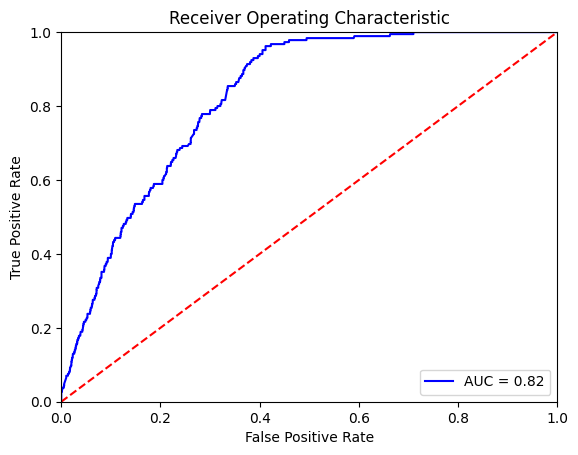

In [44]:
probas_pred=modelo_final.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test,probas_pred[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()